In [3]:
import sys

sys.path.append("..")

%load_ext autoreload
%autoreload complete

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import cf_xarray as cfxr
import cfr
import cmocean
import nc_time_axis

from lmrecon.util import lowpass_filter
from lmrecon.util import get_data_path
from lmrecon.time import convert_datetime_to_decimal_year
from lmrecon.psm import IdentityPSM, LinearPSM, PhysicalSpacePSM, PSM
from lmrecon.plotting import plot_field, add_subplot_headers, format_plot, get_field_label
from lmrecon.grid import Regridder
from lmrecon.indices import *

In [5]:
# ds = xr.open_zarr(get_data_path() / "cmip6" / "MPI-ESM1-2-LR" / "past2k" / "seasonal_anomalies.zarr").isel(time=slice(400))
# ds = xr.open_zarr(get_data_path() / "cmip6" / "CESM2" / "piControl" / "seasonal_anomalies.zarr").isel(time=slice(400))

In [6]:
ds = xr.open_dataset("/home/enkf6/dstiller/datasets/HadISST_sst.nc.gz")["sst"].sel(time=slice("1900", "2013"))
ds = xr.where(ds > -999, ds, np.nan)
ds = Regridder().regrid(ds).compute()
ds = ds.groupby("time.month") - ds.groupby("time.month").mean()
ds = ds.assign_coords(time=convert_datetime_to_decimal_year(ds.time.values))
ds

<xarray.DataArray 'sst' (time: 1368, lat: 90, lon: 180)> Size: 89MB
array([[[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
...
        [           nan,            nan,            nan, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [           nan,            nan,            nan, ...,
          0.0000000e+00,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        ...,
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 1kB 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat      (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
    month    (time) int64 11kB 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12
  * time     (time) float64 11kB 1.9e+03 1.9e+03 1.9e+03 ... 2.014e+03 2.014e+03

In [7]:
pdo = PDOIndex()
pdo.fit(ds)

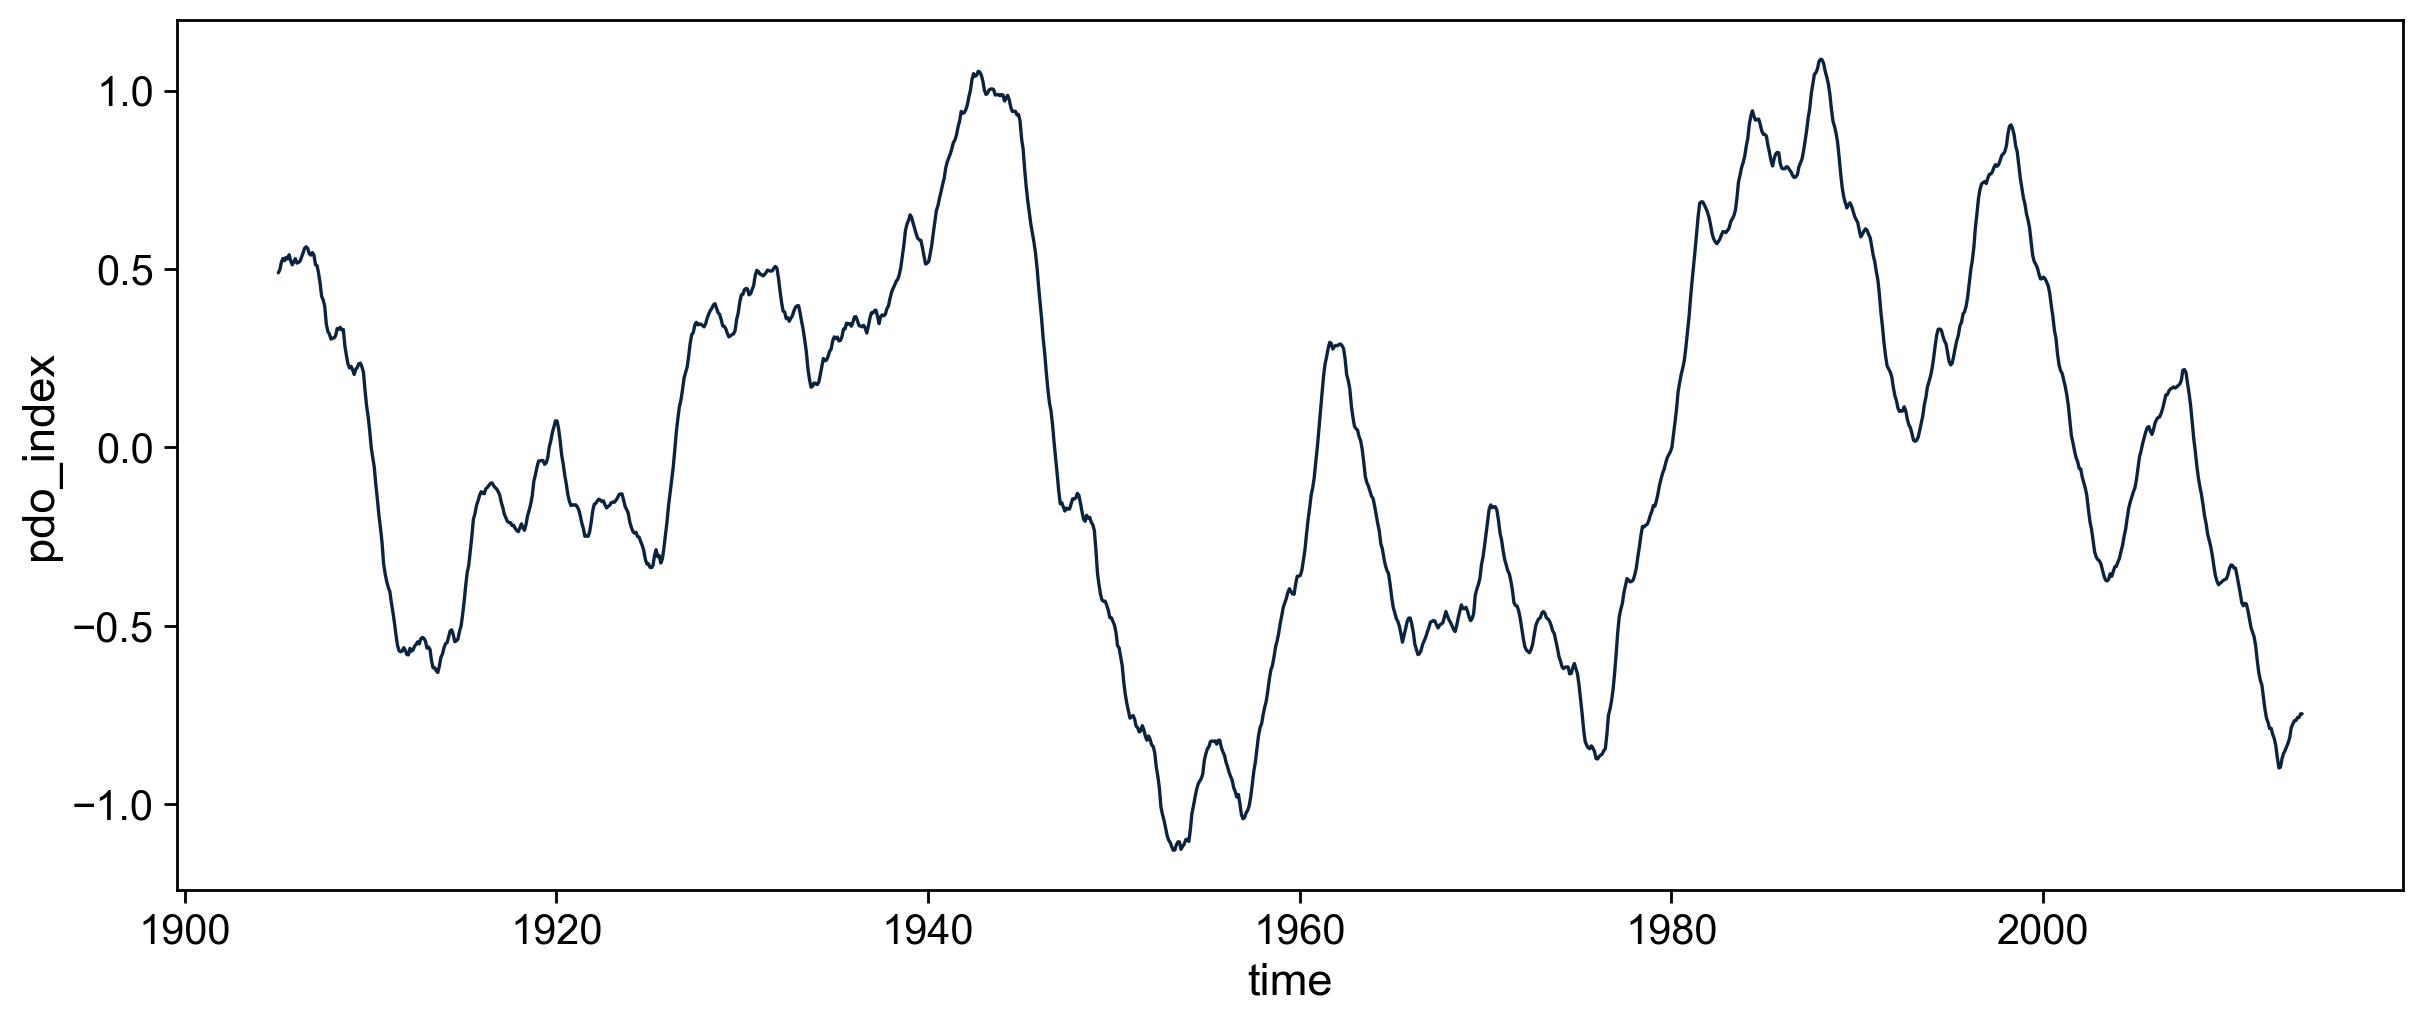

In [8]:
pdo.compute_index(ds).rolling(dict(time=61)).mean().plot()

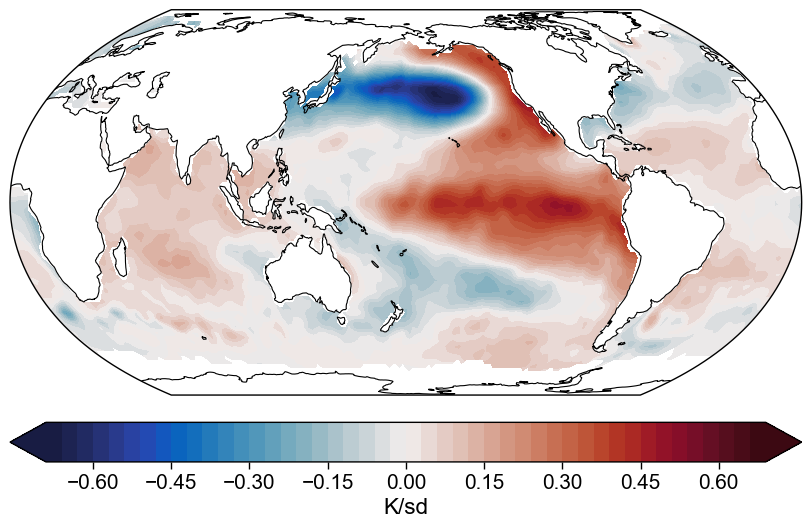

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6), subplot_kw=dict(projection=ccrs.EqualEarth(central_longitude=180)), dpi=100)
plot_field(ax, pdo.regress_field(ds, pdo.compute_index(ds)), cbar_label="K/sd")
ax.coastlines()

In [10]:
ipo = IPOTripoleIndex()
ipo.compute_index(ds)

<xarray.DataArray 'ipo_index' (time: 1368)> Size: 11kB
array([ 1.46146111,  1.27801705,  1.18911817, ..., -0.35608481,
       -0.34802243, -0.45176762])
Coordinates:
  * time     (time) float64 11kB 1.9e+03 1.9e+03 1.9e+03 ... 2.014e+03 2.014e+03

/home/disk/p/dstiller/.local/software/miniconda3/envs/lmrecon3.12/lib/python3.12/site-packages/xrscipy/signal/filters.py:244: UnevenSamplingWarning: Average sampling 0.0833 != first sampling step 0.0822
  f_crit_norm *= 2 * get_sampling_step(darray, dim)


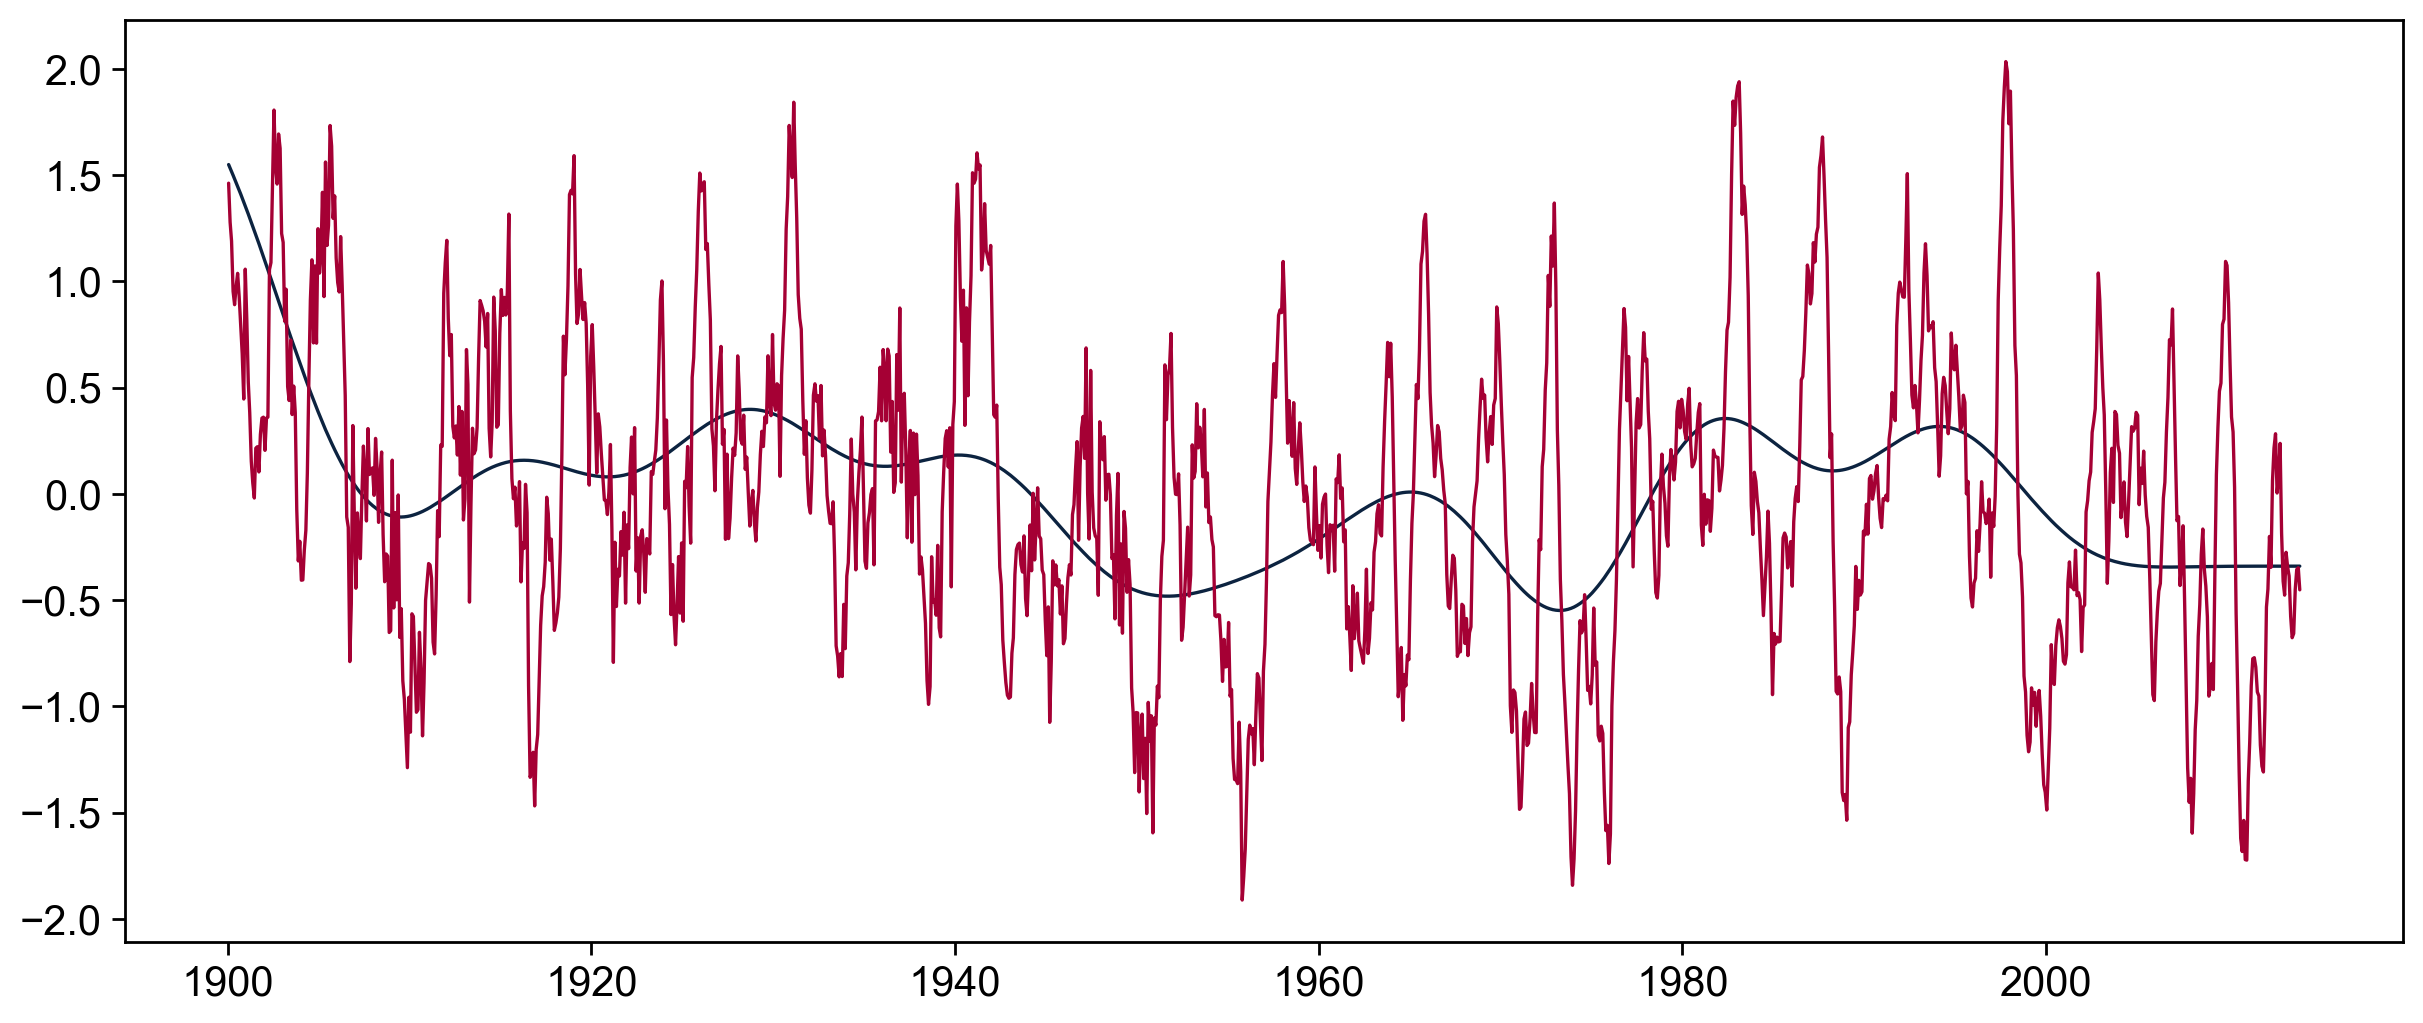

In [11]:
plt.plot(ds.time, lowpass_filter(ipo.compute_index(ds), 13))
plt.plot(ds.time, ipo.compute_index(ds))

In [12]:
nino = Nino34Index()
nino.compute_index(ds)

<xarray.DataArray 'nino34_index' (time: 1368)> Size: 11kB
array([ 1.35692356,  1.2356092 ,  1.01854165, ..., -0.13389765,
        0.08234865, -0.02687468])
Coordinates:
  * time     (time) float64 11kB 1.9e+03 1.9e+03 1.9e+03 ... 2.014e+03 2.014e+03

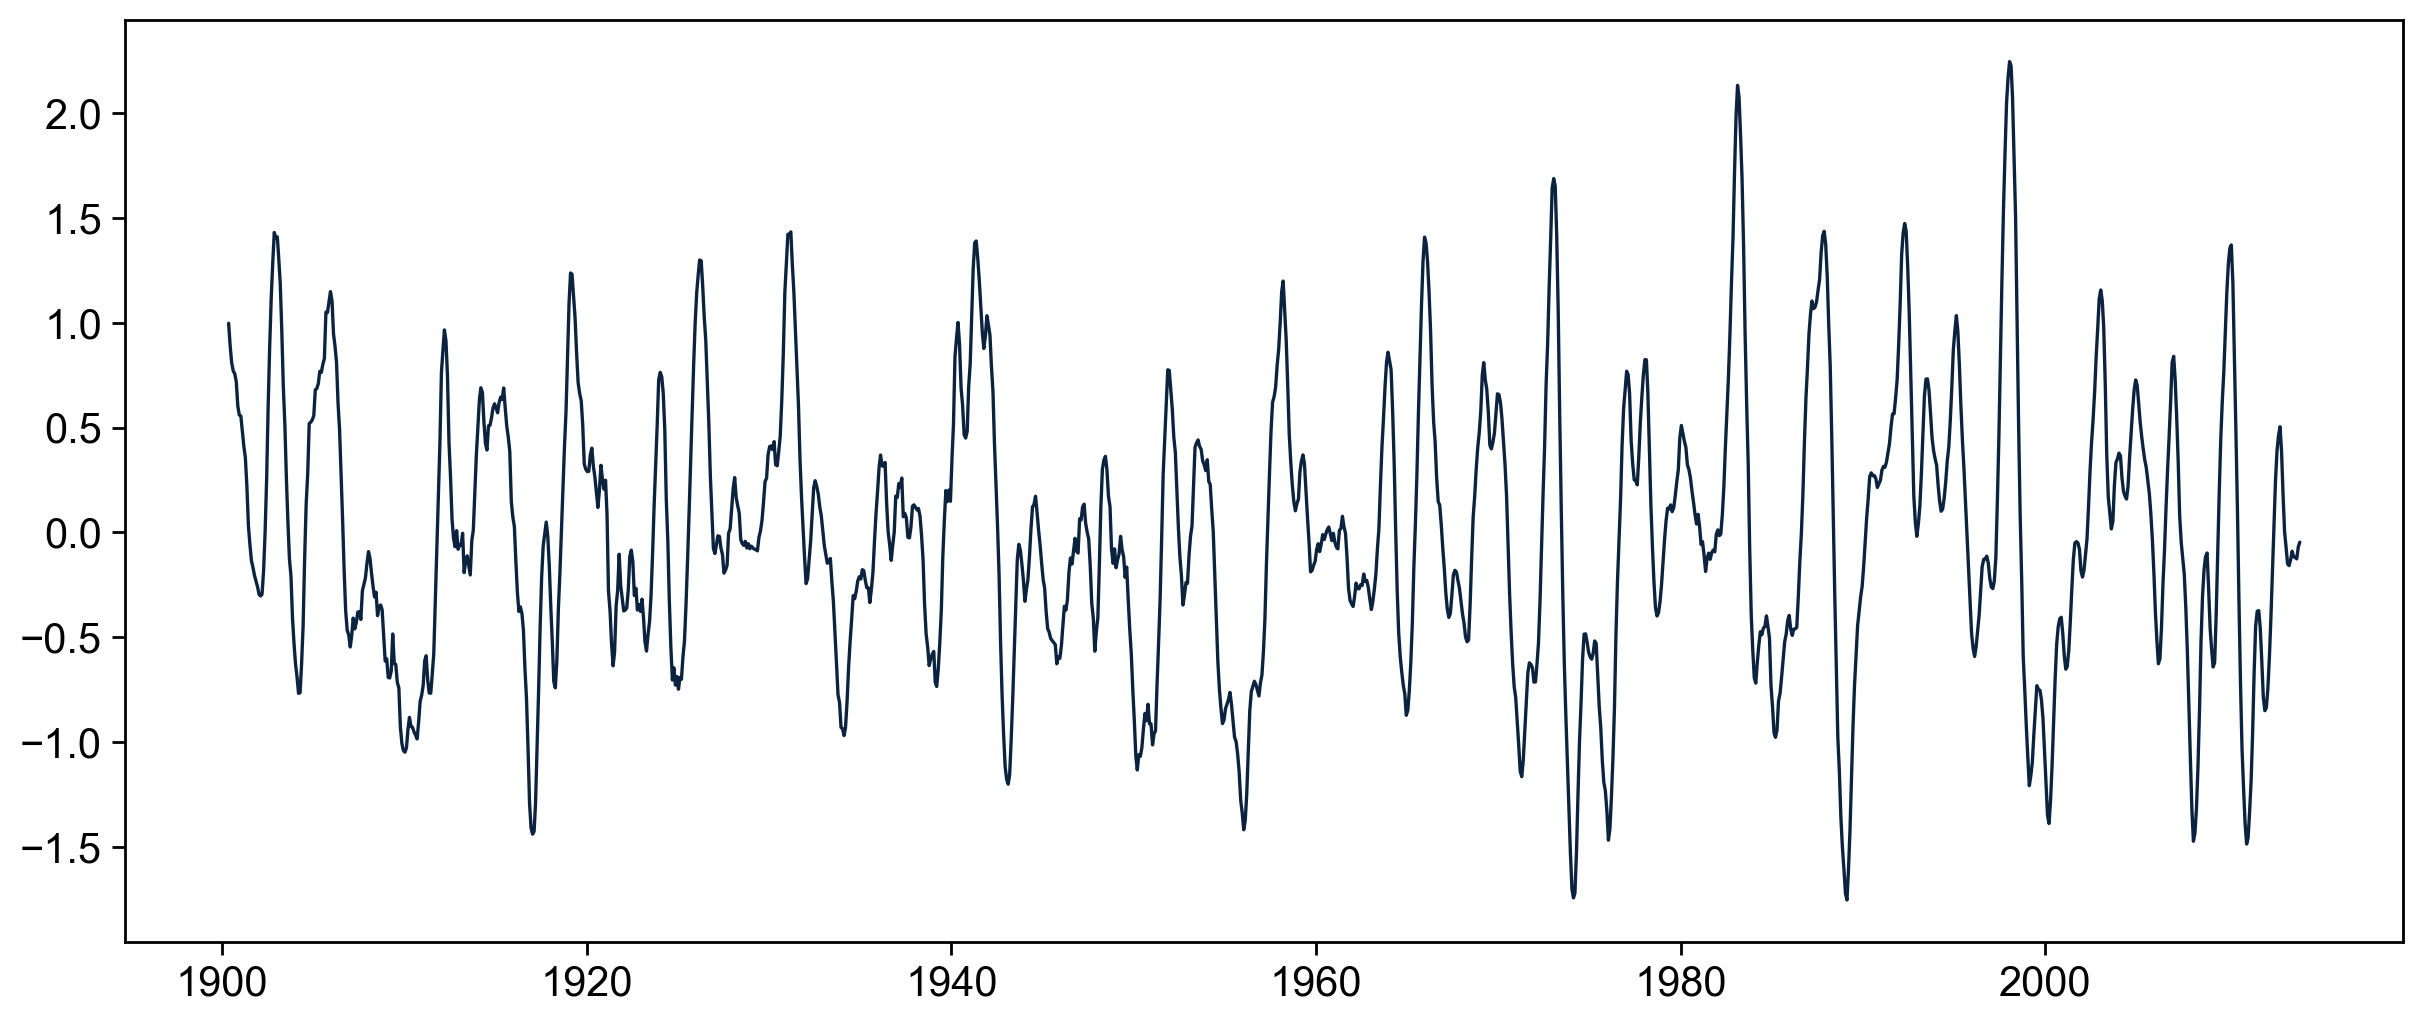

In [13]:
plt.plot(ds.time, nino.compute_index(ds).rolling(dict(time=5)).mean())

In [14]:
amo = AMOIndex()
amo.compute_index(ds)

<xarray.DataArray 'amo_index' (time: 1368)> Size: 11kB
array([0.17621677, 0.09094552, 0.09138421, ..., 0.38655401, 0.12384795,
       0.09435877])
Coordinates:
  * time     (time) float64 11kB 1.9e+03 1.9e+03 1.9e+03 ... 2.014e+03 2.014e+03

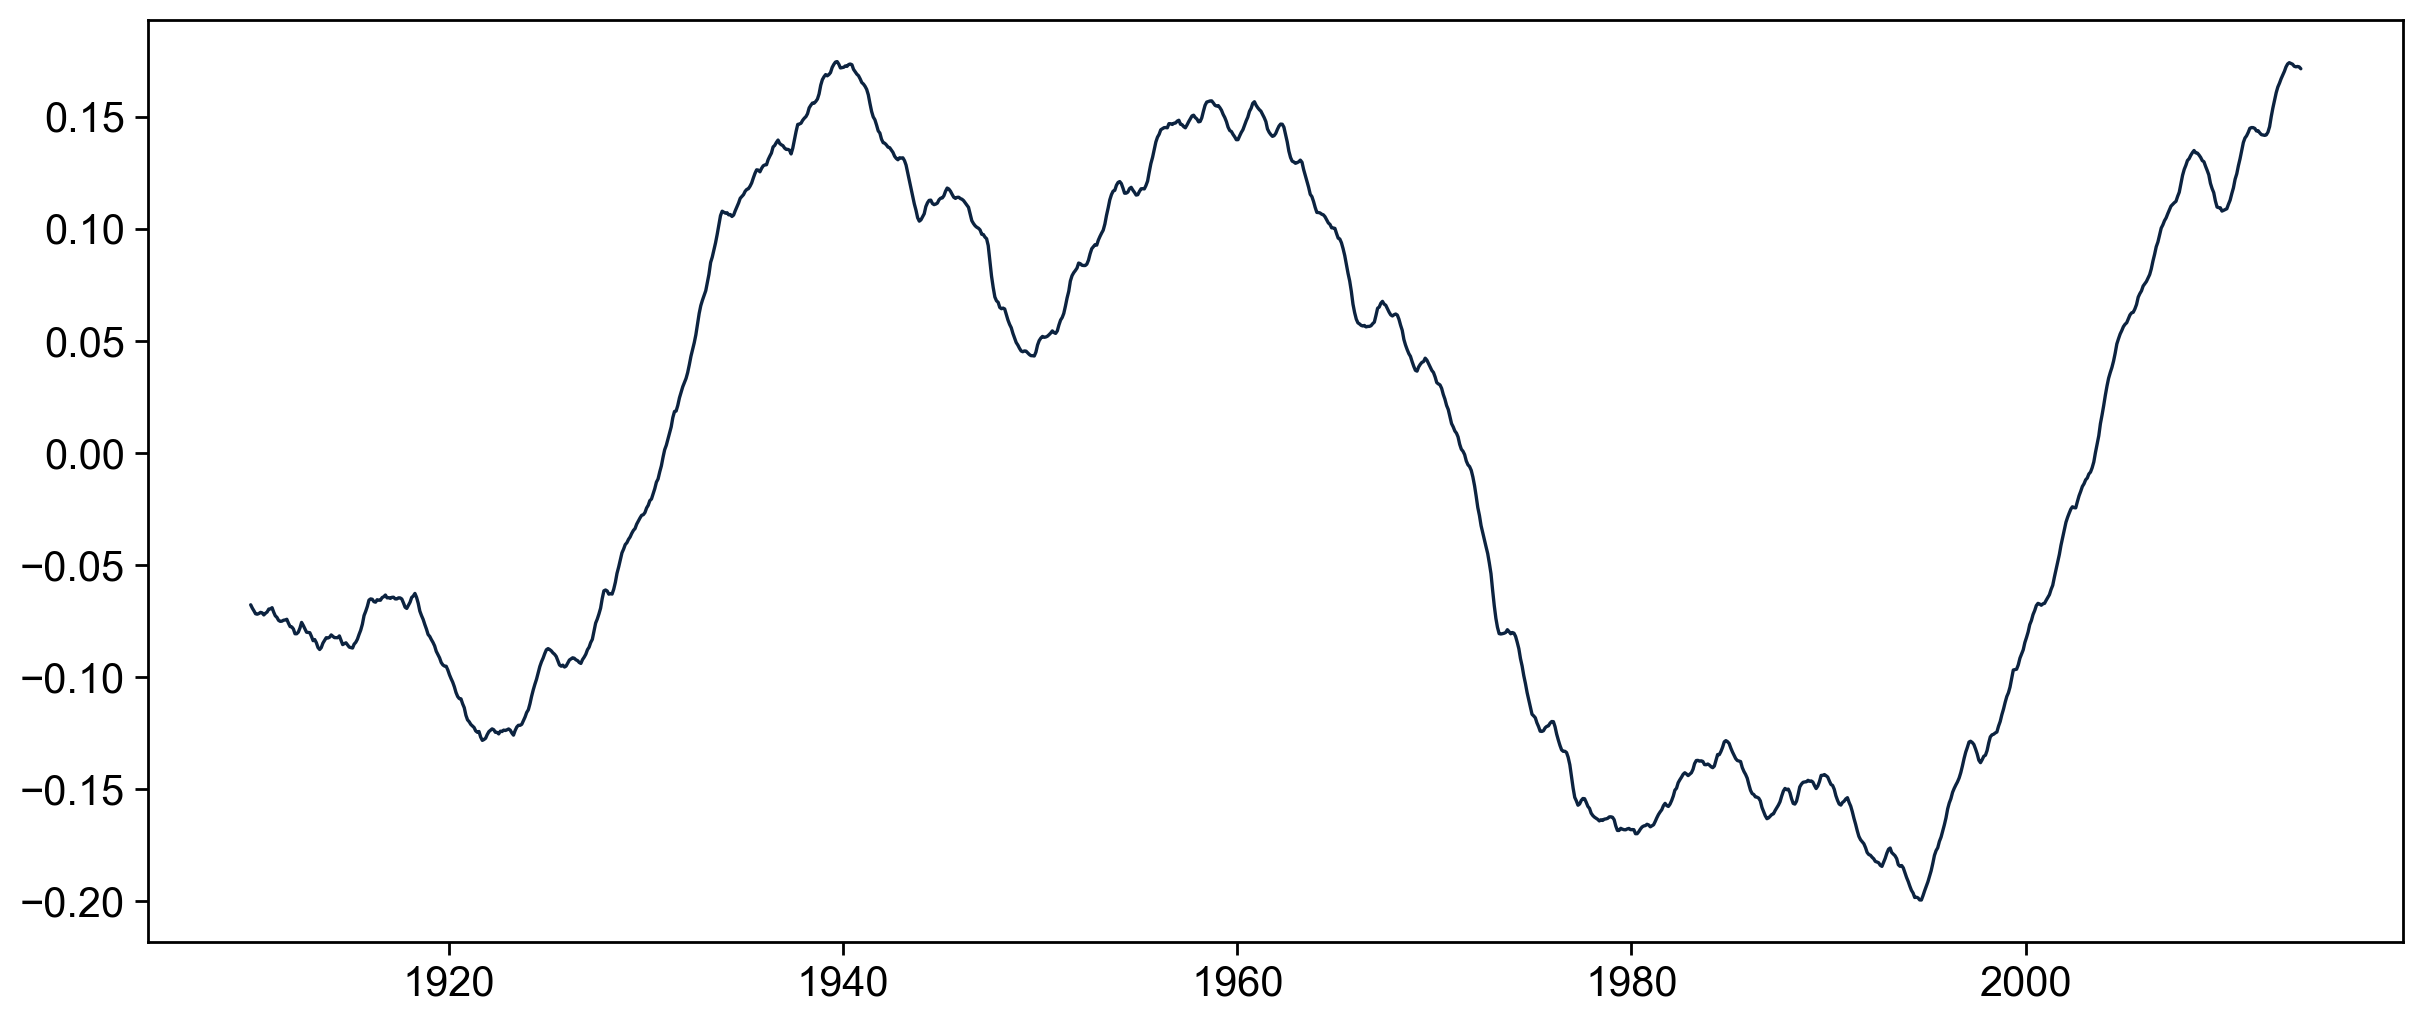

In [15]:
plt.plot(ds.time, amo.compute_index(ds).rolling(dict(time=10*12)).mean())

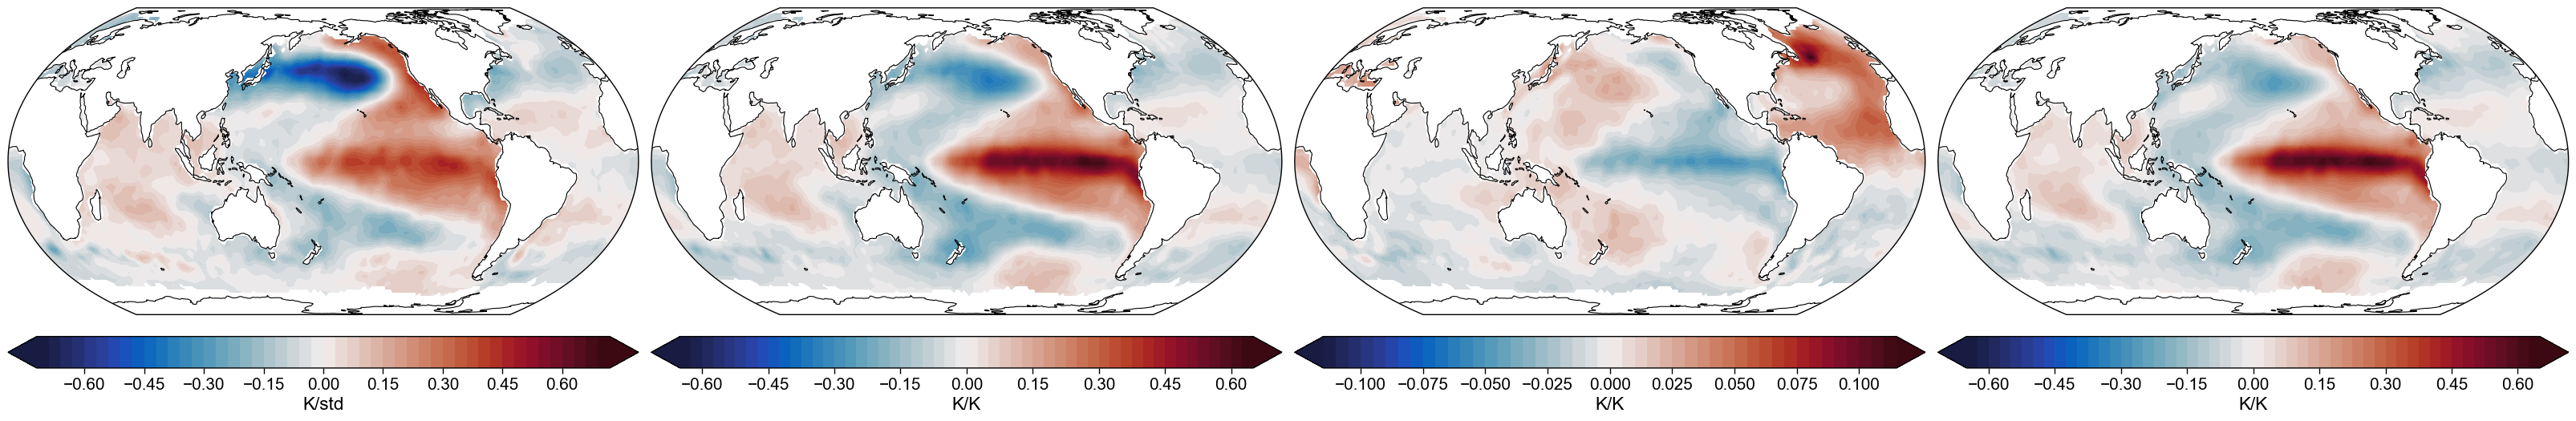

In [16]:
fig, axs = plt.subplots(1, 4, figsize=(8*4, 6), subplot_kw=dict(projection=ccrs.EqualEarth(central_longitude=180)), dpi=100)
plot_field(axs[0], pdo.regress_field(ds, pdo.compute_index(ds)), cbar_label="K/std")
plot_field(axs[1], ipo.regress_field(ds, ipo.compute_index(ds)), cbar_label="K/K")
plot_field(axs[2], amo.regress_field(ds, amo.compute_index(ds)), cbar_label="K/K")
plot_field(axs[3], nino.regress_field(ds, nino.compute_index(ds)), cbar_label="K/K")
for ax in axs:
    ax.coastlines()